## 2.4 파이토치 코드 맛보기
1. price(자동차 가격)
2. maint(자동차 유지 비용)
3. doors(자동차 문 개수)
4. persons(수용 인원)
5. lug_capacity(수하물 용량)
6. safety(안전성)
7. output(차 상태)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving car_evaluation.csv to car_evaluation.csv


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
dataset = pd.read_csv('car_evaluation.csv')
dataset.columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety', 'output']
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


<Axes: ylabel='count'>

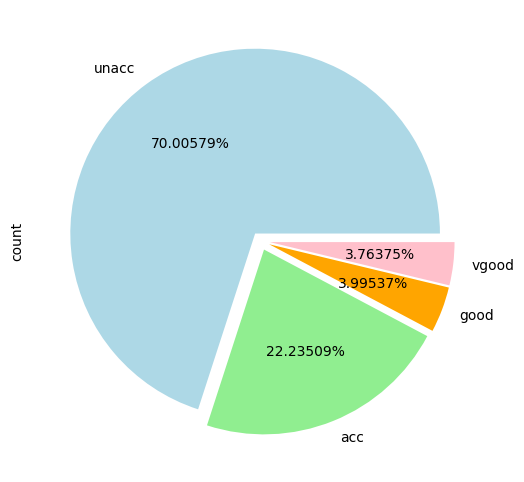

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%',
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'],
                                   explode=(0.05, 0.05, 0.05, 0.05))

- 데이터 전처리: 분석하기 좋도록 데이터를 수정
- astype()을 이용해 범주 특성을 갖는 데이터를 범주형 타입으로 변환


In [ ]:
categorical_columns = ['price', 'maint',
                       'doors', 'persons',
                       'lug_capacity', 'safety']  # 예제 데이터셋 칼럼들의 목록

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category') # astype() 메서드 -> 데이터를 범주형으로 변환

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]  # 합친 넘파이 배열 중 10개의 행 출력

array([[3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1],
       [3, 3, 0, 1, 2, 2]], dtype=int8)

1. 범주형 데이터를 텐서로 변환하기 위해 다음의 절차가 필요
- 범주형 데이터 -> dataset[category] -> 넘파이 배열 -> 텐서

2. np.stack은 두 개 이상의 넘파이 객체를 합칠 때 사용

In [ ]:
# torch 모듈을 이용하여 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1],
        [3, 3, 0, 1, 2, 2]])

In [ ]:
# 레이블로 사용할 칼럼도 텐서로 변환
# get_dummies를 이용하여 넘파이 배열로 변환
outputs = pd.get_dummies(dataset.output)    # [1]
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()   # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1727, 6])
torch.Size([6908])


1. get_dummies는 가변수로 만들어 주는 함수로 가변수를 만들어 준다는 의미는 문자를 숫자(0,1)로 바꾸어준다는 의미

In [ ]:
# 성별, 몸무게, 국적이라는 칼럼을 갖는 배열 생성
import pandas as pd
import numpy as np

data = {
    'gender': ['male', 'female', 'male'],
    'weight': [72,55,68],
    'nation': ['Japsn', 'Korea', 'Australia']
}
df = pd.DataFrame(data)
df

,gender,weight,nation
0,male,72,Japsn
1,female,55,Korea
2,male,68,Australia


In [ ]:
pd.get_dummies(df).astype('int')

,weight,gender_female,gender_male,nation_Australia,nation_Japsn,nation_Korea
0,72,0,1,0,1,0
1,55,1,0,0,0,1
2,68,0,1,1,0,0


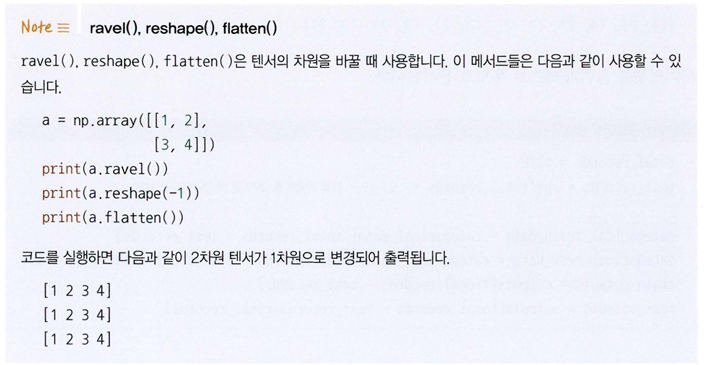

In [ ]:
# 범주형 칼럼을 N차원으로 변환

categorical_column_sizes = [len(dataset[column].cat.categories) for
                            column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for
                               col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [ ]:
# 데이터셋 분리
total_records = 1728
test_records = int(total_records * .2)   # 전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [ ]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
344
345


In [ ]:
# 모델의 네트워크 생성
class Model(nn.Module): # [1]
    def __init__(self, embedding_size, output_size, layers, p=0.4):  # [2]
        super().__init__()  # [3]
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for
                                         ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:  # [4]
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace = True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):  # [5]
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))

        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

(1) 클래스 형태로 구현되는 모델은 nn.Module을 상속
(2) __init__()은 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며, 객체가 생성될 때 자동으로 호출, __init__()에서 전달되는 매개변수는 다음과 같음.
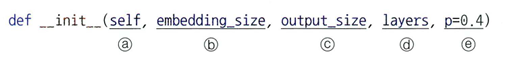

  - (a): 첫 번쨰 파라미터는 self를 지정해야 하며 자기 자신을 의미
  - (b): embedding_size: 범주형 칼럼의 임베딩 크기
  - (c): output_size: 출력층의 크기
  - (d): layers: 모든 계층에 대한 목록
  - (e): p: 드롭아웃(기본값은 0.5)

(3) super().__init__()은 부모 클래스(nn.Module)에 접근할 떄 사용
(4) 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가함.
  - linear: 선형 계층(linear layer)은 입력 데이터에 선형 변환을 진행한 결과
    - y = Wx + B
    - RELU: 활성화 함수로 사용
    - BatchNorm1d: 배치 정규화 용도로 사용
    - Dropout: 과적합 방지에 사용

(5) forward() 함수는 학습 데이터를 입력받아서 연산을 진행, forward() 함수는 모델 객체를 데이터와 함꼐 호출하면 자동으로 실행

In [ ]:
# Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [ ]:
# 모델의 파라미터 정의
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# CPU/GPU 사용 지정
if torch.cuda.is_available():
    device = torch.device('cuda')  # GPU가 있으면 GPU 사용
else:
    device = torch.device('cpu')   # 없으면 CPU 사용

In [ ]:
# 모델 학습
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):   # for문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)   # 반복할 때마다 오치를 aggregated_losses에 추가

    if i%25 == 1:
        print(f'epoch: {1:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()   # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step()         # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트

print(f'epoch: {1:3} loss: {single_loss.item():10.10f}')  # 오차가 25 에포크마다 출력

epoch:   1 loss: 1.63558292
epoch:   1 loss: 1.43888140
epoch:   1 loss: 1.33545542
epoch:   1 loss: 1.21833754
epoch:   1 loss: 1.07998037
epoch:   1 loss: 0.96579295
epoch:   1 loss: 0.86440814
epoch:   1 loss: 0.75857341
epoch:   1 loss: 0.70182490
epoch:   1 loss: 0.66811520
epoch:   1 loss: 0.64212030
epoch:   1 loss: 0.64202076
epoch:   1 loss: 0.61141443
epoch:   1 loss: 0.60596871
epoch:   1 loss: 0.59806502
epoch:   1 loss: 0.58718961
epoch:   1 loss: 0.58992904
epoch:   1 loss: 0.57419282
epoch:   1 loss: 0.58297807
epoch:   1 loss: 0.57280380
epoch:   1 loss: 0.5739449263


In [ ]:
min_len = min(y_val.shape[0], test_outputs.shape[0])
y_val = y_val[:min_len]
test_outputs = test_outputs[:min_len]

In [ ]:
# 테스트 데이터셋으로 모델 예측
test_outputs = test_outputs.to(device = device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.55907881


In [ ]:
# 모델의 예측 확인
print(y_val[:5])

tensor([[ 2.1670,  1.6003, -2.0247, -1.9189],
        [ 1.8057,  1.5438, -2.0439, -2.4797],
        [ 1.9946,  1.1731, -2.6793, -2.5559],
        [ 2.0986,  1.4954, -2.3075, -2.2704],
        [ 1.8200,  1.4517, -2.4178, -2.5294]])


In [ ]:
# 가장 큰 값을 갖는 인덱스 확인
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [ ]:
# 테스트 데이터셋을 이용한 정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[257   1]
 [ 83   3]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       258
           1       0.75      0.03      0.07        86

    accuracy                           0.76       344
   macro avg       0.75      0.52      0.46       344
weighted avg       0.75      0.76      0.66       344

0.7558139534883721


- 딥러닝 분류 모델의 성능 평가 지표
  - 정확도, 재현율, 정밀도, F1-스코어
  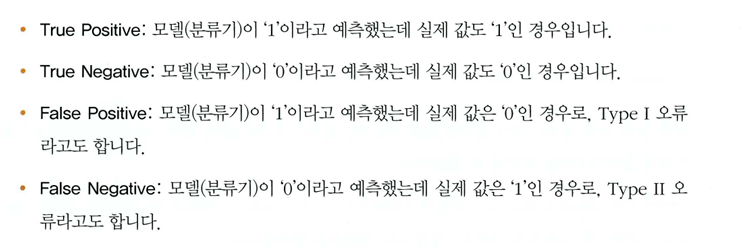

- 정확도: 전체 예측 건수에서 정답을 맞힌 건수의 비율

- 재현율: 실제 정답이 1이라고 할 때 모델도 1로 예측한 비율

- 정밀도: 모델이 1이라고 예측한 것 중에서 실제로 정답이 1인 비율

- F1-스코어: 정밀도와 재현율은 트레이드오프 관계이므로 따라서 정밀도와 재현율의 조화평균을 이용한 것